# Plotting Baseline vs. Mitigated Results (Point-Line Plot)

**Objective:** Generate faceted point-line graphs comparing Baseline vs. Mitigated results for %ΔGAP and NDCG@10 metrics, specifically focusing on the **'high' user group**. Each subplot represents a Domain/Popularity Notion combination. Lines represent different combinations of Mitigation status and Evaluation Strategy.

**Data Source:** `consolidated_results.csv` (Baseline) and `consolidated_mitigated_results.csv` (Mitigated).

In [1]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# --- Style ---
sns.set_theme(style="whitegrid")
algo_order = ["MostPop", "UserKNN", "ItemKNN", "PMF", "NMF", "HPF"] # Consistent algorithm order

In [3]:
# --- Load Data ---
try:
    df_base = pd.read_csv('consolidated_results.csv')
    df_miti = pd.read_csv('consolidated_mitigated_results05.csv')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Ensure consolidated_results.csv and consolidated_mitigated_results.csv are present.")
    # exit() # Uncomment to stop execution if files are missing
except Exception as e:
    print(f"Error loading data: {e}")
    # exit()

Data loaded successfully.


In [4]:
# --- Preprocessing ---
# Add mitigation status column
df_base['Mitigation'] = 'Baseline'
df_miti['Mitigation'] = 'Mitigated'

# Combine dataframes
df_combined = pd.concat([df_base, df_miti], ignore_index=True)

# Filter for 'high' user group and relevant metrics
df_filtered = df_combined[
    (df_combined['user_group'] == 'high') &
    (df_combined['metric_type'].isin(['NDCG', 'GAP']))
].copy()

# Convert value to numeric, coercing errors
df_filtered['value'] = pd.to_numeric(df_filtered['value'], errors='coerce')

print(f"Filtered data shape: {df_filtered.shape}")
# Check for missing values introduced
print(f"NaN values in 'value' column after filtering/conversion: {df_filtered['value'].isna().sum()}")

Filtered data shape: (288, 10)
NaN values in 'value' column after filtering/conversion: 0


### Plotting Function

In [5]:
# --- Plotting Function ---
def plot_comparison_point_line(df, metric, domains, pop_notions, algo_order):
    """
    Generates faceted point-line plots comparing baseline vs. mitigated results.
    Facets: Domain (row), Popularity Notion (column)
    X-axis: Algorithm
    Color: Baseline/Mitigated
    Line Style: Evaluation Strategy
    Markers: Added for clarity
    """
    df_metric = df[df['metric_type'] == metric].copy()

    if df_metric.empty:
        print(f"No data to plot for metric: {metric}")
        return

    # Sort pop_notions for consistent subplot order
    pop_notions = sorted(pop_notions)
    num_pop_notions = len(pop_notions)
    num_domains = len(domains)

    fig, axes = plt.subplots(num_domains, num_pop_notions,
                             figsize=(6 * num_pop_notions, 5 * num_domains),
                             sharey=True, squeeze=False) # Ensure axes is always 2D

    fig.suptitle(f"Baseline vs. Mitigated {metric}{'@10' if metric == 'NDCG' else ''} for 'High' User Group",
                 fontsize=16, y=1.02)

    # Define visual mappings
    colors = {'Baseline': 'royalblue', 'Mitigated': 'firebrick'} # Blue for Baseline, Red for Mitigated
    linestyles = {'eva_two': '-', 'eva_three': '--'} # Solid for eva_two, Dashed for eva_three
    markers = {'eva_two': 'o', 'eva_three': 's'} # Circle for eva_two, Square for eva_three
    label_patterns = {
        ('Baseline', 'eva_two'): f"Baseline (eva_two)",
        ('Mitigated', 'eva_two'): f"Mitigated (eva_two)",
        ('Baseline', 'eva_three'): f"Baseline (eva_three)",
        ('Mitigated', 'eva_three'): f"Mitigated (eva_three)",
    }

    for r, domain in enumerate(domains):
        for c, pop_notion in enumerate(pop_notions):
            ax = axes[r, c]
            df_plot = df_metric[
                (df_metric['domain'] == domain) &
                (df_metric['popularity_notion'] == pop_notion)
            ].copy()

            if df_plot.empty:
                ax.set_title(f"{domain.capitalize()} / {pop_notion}\n(No Data)", fontsize=12)
                ax.set_xticks(np.arange(len(algo_order))) # Use numerical positions for xticks
                ax.set_xticklabels(algo_order, rotation=45, ha='right')
                # Add Y label only if it's the first column in the middle row
                if c == 0 and r == (num_domains // 2):
                     ax.set_ylabel(f"{metric}{'@10' if metric == 'NDCG' else ''} Value", fontsize=12)
                continue

            # Pivot for easier access
            df_pivot = df_plot.pivot_table(index='algorithm',
                                           columns=['Mitigation', 'evaluation_strategy'],
                                           values='value')
            df_pivot = df_pivot.reindex(algo_order) # Ensure order and handle missing algos

            # Plot the 4 lines
            for mitigation_status in ['Baseline', 'Mitigated']:
                for eval_strategy in ['eva_two', 'eva_three']:
                    column_tuple = (mitigation_status, eval_strategy)
                    # Check if the column exists (pivot might not create all 4 if data is missing)
                    if column_tuple in df_pivot.columns:
                        values = df_pivot[column_tuple].values
                        label = label_patterns[column_tuple]
                        ax.plot(df_pivot.index, # Use algorithm names directly for plotting x-axis categories
                                values,
                                color=colors[mitigation_status],
                                linestyle=linestyles[eval_strategy],
                                marker=markers[eval_strategy],
                                label=label,
                                linewidth=2.5, # Make lines thicker
                                markersize=7) # Make markers clearer
                    # else: # Option to plot placeholder for missing data
                       # ax.plot(df_pivot.index, np.full(len(df_pivot.index), np.nan), label=f"{mitigation_status} ({eval_strategy}) - N/A")
                       # pass # Or just don't plot it

            # --- Formatting ---
            ax.set_title(f"{domain.capitalize()} / {pop_notion}", fontsize=12)
            ax.set_xticks(np.arange(len(algo_order))) # Set numerical positions for ticks
            ax.set_xticklabels(algo_order, rotation=45, ha='right') # Set labels for ticks
            ax.tick_params(axis='x', labelsize=10)
            ax.tick_params(axis='y', labelsize=10)
            ax.grid(True, axis='y', linestyle='--', alpha=0.7)

            # Only add Y label to the first column in the middle row
            if c == 0 and r == (num_domains // 2):
                 ax.set_ylabel(f"{metric}{'@10' if metric == 'NDCG' else ''} Value", fontsize=12)

            # Add horizontal line at y=0 for GAP plots
            if metric == 'GAP':
                ax.axhline(0, color='grey', linewidth=0.8, linestyle=':')

    # --- Create Legend --- based on lines plotted in the *last* valid subplot
    # Find last axes that actually plotted data
    last_ax_with_data = None
    for r_idx in range(num_domains - 1, -1, -1):
        for c_idx in range(num_pop_notions - 1, -1, -1):
            if axes[r_idx, c_idx].has_data():
                last_ax_with_data = axes[r_idx, c_idx]
                break
        if last_ax_with_data:
            break

    if last_ax_with_data:
        handles, labels_legend = last_ax_with_data.get_legend_handles_labels()
        # Filter out potential "N/A" labels if added above
        # handles = [h for h, l in zip(handles, labels_legend) if "N/A" not in l]
        # labels_legend = [l for l in labels_legend if "N/A" not in l]
        fig.legend(handles, labels_legend, loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=4, title="Mitigation & Eval Strategy", fontsize=10)
    else:
        print("Warning: Could not find any axes with data to create legend.")

    plt.tight_layout(rect=[0, 0, 1, 0.94]) # Adjust layout further for legend
    plt.show()

### Generate Plots


Generating NDCG plot (Point-Line)...


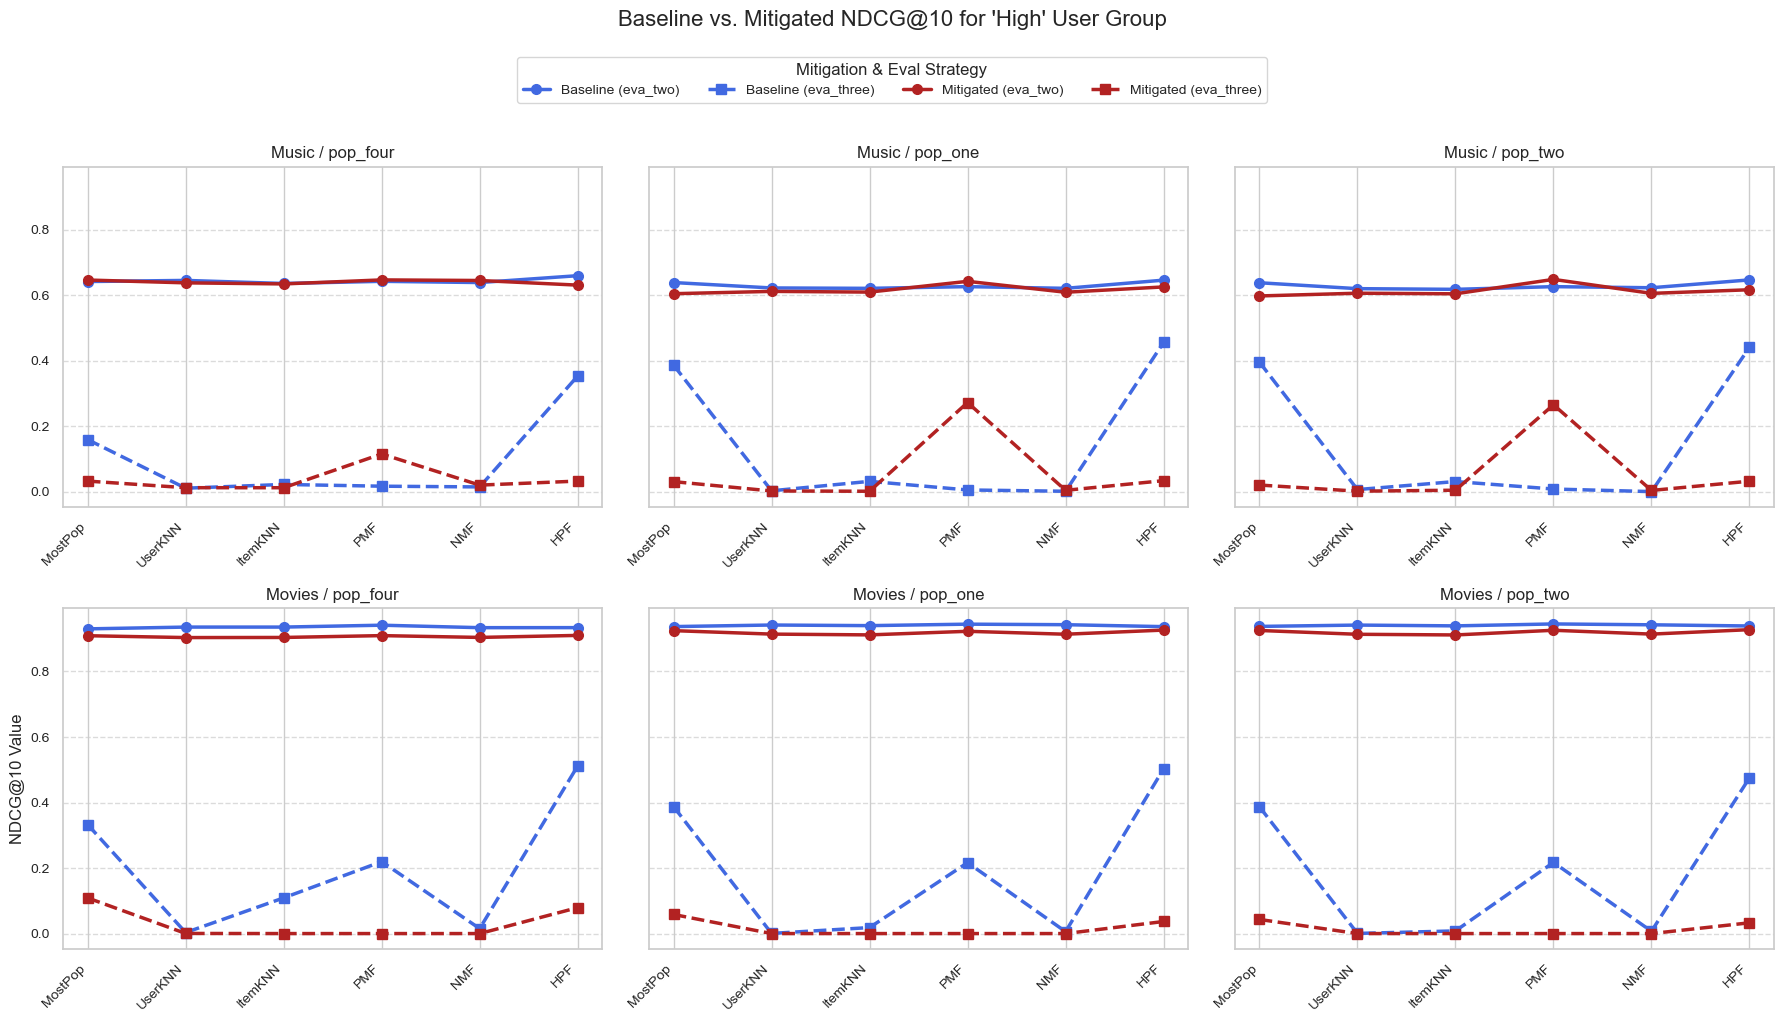


Generating GAP plot (Point-Line)...


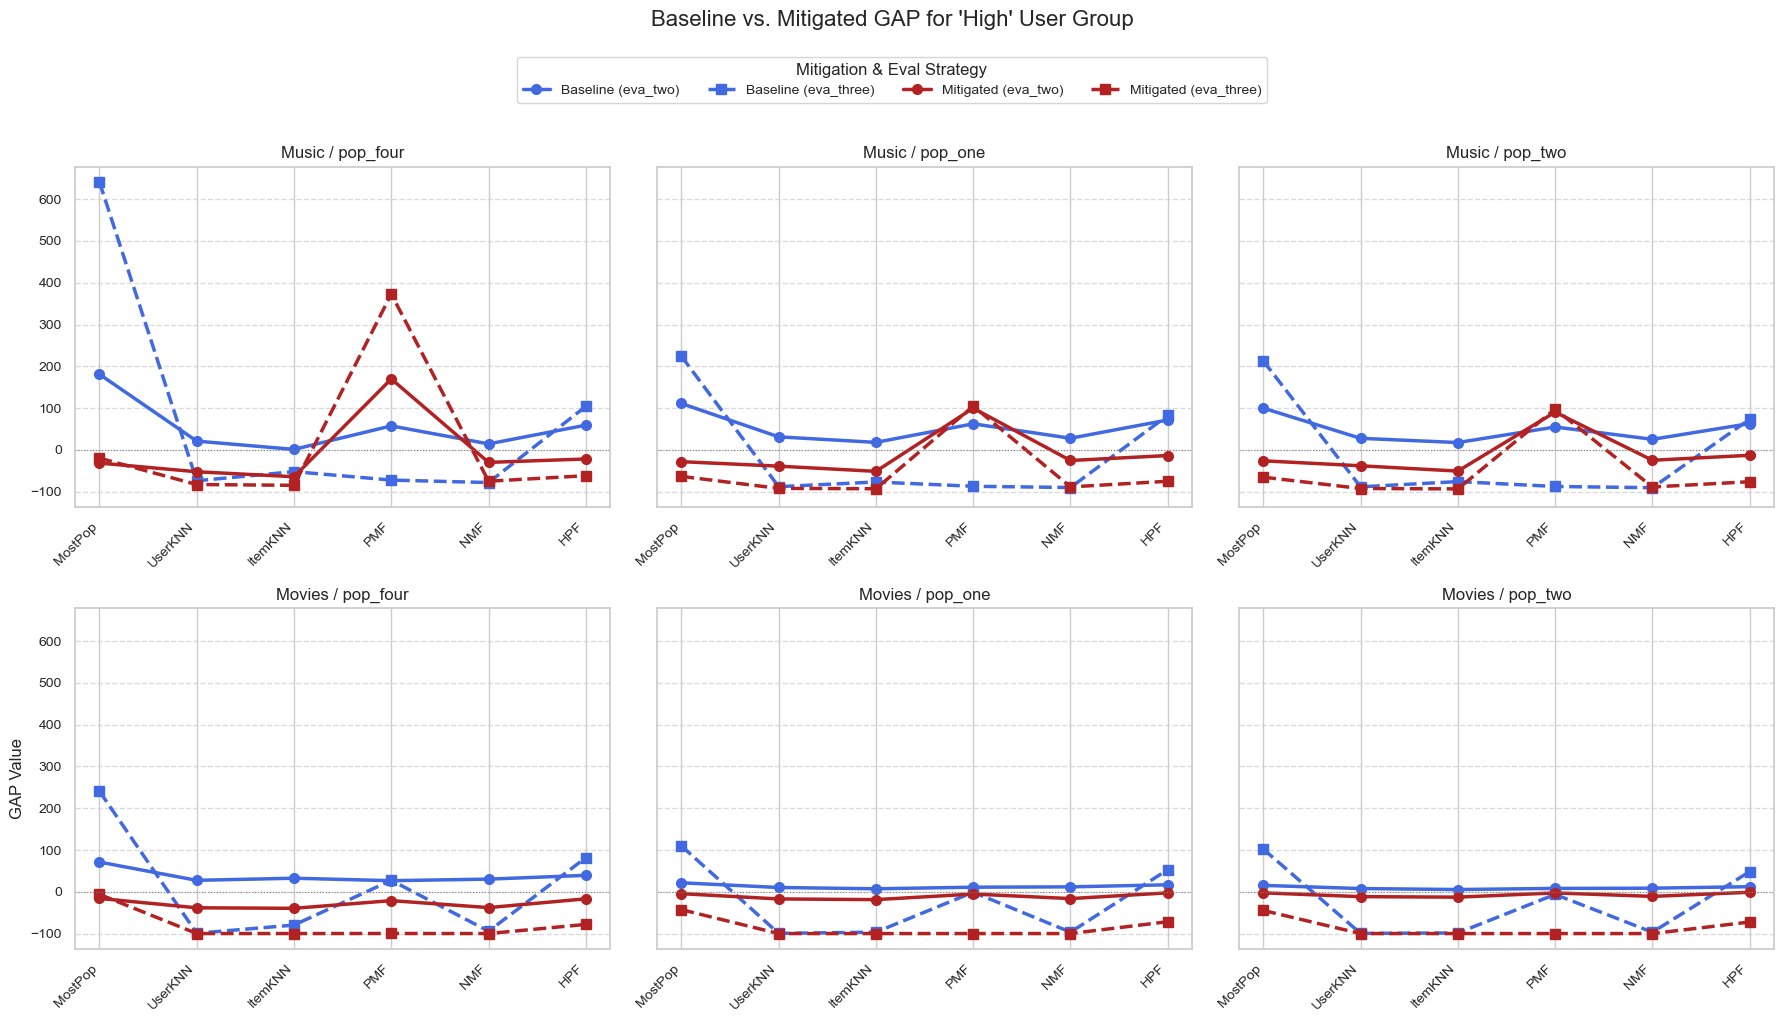

In [6]:
# --- Generate Plots ---
domains = df_filtered['domain'].unique()
# Ensure pop_notions are sorted if desired, e.g., pop_one, pop_two, pop_four
pop_notions = sorted(df_filtered['popularity_notion'].unique())

print("\nGenerating NDCG plot (Point-Line)...")
plot_comparison_point_line(df_filtered, 'NDCG', domains, pop_notions, algo_order)

print("\nGenerating GAP plot (Point-Line)...")
plot_comparison_point_line(df_filtered, 'GAP', domains, pop_notions, algo_order)

**Interpretation Note:**
- **Color:** Blue = Baseline, Red = Mitigated (alpha=0.5).
- **Line Style:** Solid = `eva_two` (UserTest), Dashed = `eva_three` (TrainItems).
- **Markers:** Circle = `eva_two`, Square = `eva_three`.